# Shape optimization of a fillet
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/optimization/planar/shape.ipynb)

In [1]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from torchfem.examples import get_example_file
from torchfem.io import import_mesh
from torchfem.materials import IsotropicElasticityPlaneStress

torch.set_default_dtype(torch.float64)

## Import reference model
This imports the reference model, sets up boundary conditions and computes the initial stresses prior to optimization.

In [2]:
# Material model (plane stress)
material = IsotropicElasticityPlaneStress(E=1000.0, nu=0.3)

# Import mesh
specimen = import_mesh(get_example_file("fillet.vtu"), material)

# Symmetry nodes
left = specimen.nodes[:, 0] < 0.1
specimen.constraints[left, 0] = True
bottom = specimen.nodes[:, 1] < 0.1
specimen.constraints[bottom, 1] = True

# Load at right end
right = specimen.nodes[:, 0] >= specimen.nodes[:, 0].max() - 0.1
specimen.constraints[right, 0] = True
specimen.displacements[right, 0] = 6.0

Maximum v.Mises stress is 164.19.


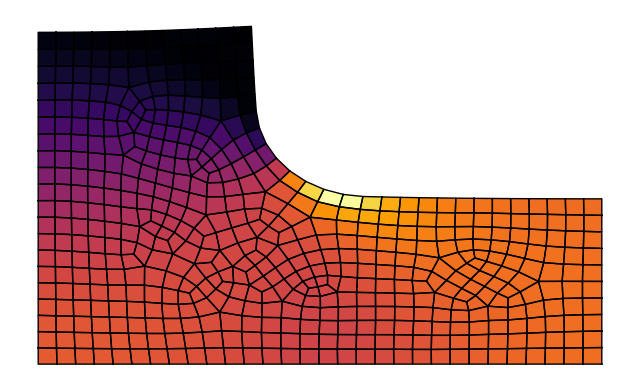

In [3]:
u, f, σ, ε, α = specimen.solve()
mises = torch.sqrt(σ[:, 0] ** 2 - σ[:, 0] * σ[:, 1] + σ[:, 1] ** 2 + 3 * σ[:, 2] ** 2)
specimen.plot(u, bcs=False, element_property=mises, cmap="inferno")
max_mises = torch.max(mises)
print(f"Maximum v.Mises stress is {max_mises:.2f}.")

## Mesh morphing with radial basis functions
The `morph` function applies a shape change to a region of the mesh. It uses radial basis functions to regularize the shape change.

In [4]:
# Radial basis function
r = torch.cdist(specimen.nodes, specimen.nodes)
epsilon = 0.2
phi = torch.exp(-((epsilon * r) ** 2))


def morph(fem, nids, x, dir):
    # Build matrix
    M = phi[:, nids]
    M = M[nids, :]
    # Solve linear equation system
    weights = torch.linalg.solve(M, x - fem.nodes[nids, dir])
    # Apply deformation
    fem.nodes[:, dir] += weights @ phi[nids, :]

## Control nodes 

We use a set of control nodes as design variables, which may be used to modify the shape. These nodes are located along the fillet radius.

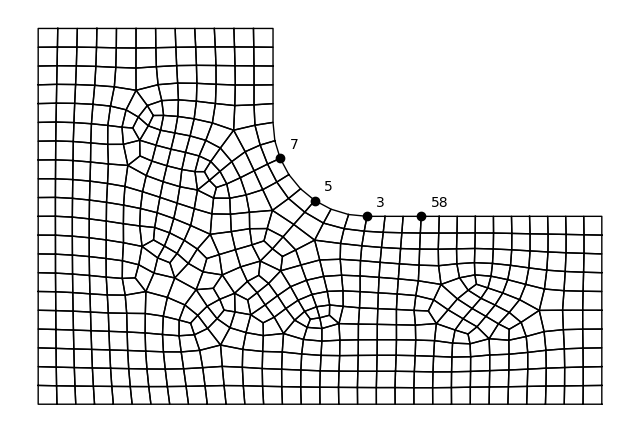

In [5]:
control_nodes = [3, 5, 7, 58]

# Plot the base mesh
specimen.plot(bcs=False)

# Plot control nodes
cx = specimen.nodes[control_nodes, 0]
cy = specimen.nodes[control_nodes, 1]
plt.scatter(cx, cy, marker="o", color="black")
for node in control_nodes:
    plt.annotate(str(node), (specimen.nodes[node, 0] + 1, specimen.nodes[node, 1] + 1))

## Shape optimization

The objective function $f$ uses a set of control nodes to morph the mesh and compute the resulting top N stresses. It returns the an aggregate of the v. Mises stresses, which should be minimized. The aggregate is computed with the Kreisselmeier–Steinhauser function 
$$
\sigma_{agg} = \frac{1}{\eta} \ln \sum_i^N \exp\left(\eta \bar{\sigma}_i\right)
$$
with 
$$
\bar{\sigma}_i = \frac{\sigma_\text{mises}}{\sigma_\text{mises}^\text{0,max}} - 1,
$$
where $\sigma_\text{mises}^\text{0,max}$ is the maximum v.Mises stress in the first iteration and $\eta$ is a regularization parameter.

This aggregate is chosen to regularize the problem. If only the maximum would be chosen, the responsible maximum stressed element might jump from iteration to iteration.

In [6]:
def f(x):
    # Detach previous gradients
    specimen.nodes = specimen.nodes.detach()
    # Update nodes
    morph(specimen, control_nodes, x, 1)
    # Solve fem with updated nodes
    _, _, σ, _, _ = specimen.solve()
    # Compute stress
    mises = torch.sqrt(
        σ[:, 0] ** 2 - σ[:, 0] * σ[:, 1] + σ[:, 1] ** 2 + 3 * σ[:, 2] ** 2
    )
    # Compute Kreisselmeier–Steinhauser function to aggregate stresses
    eta = 10.0
    agg = 1 / eta * torch.log(torch.sum(torch.exp(eta * (mises / max_mises - 1))))
    # Return average of top stresses
    return agg

In [7]:
# Initial values (= current y node positions)
x = torch.tensor(specimen.nodes[control_nodes, 1].numpy(), requires_grad=True)
# Optimizer settings
optimizer = torch.optim.Adam([x], lr=0.04)
# Variable to store intermediate values
stresses = []

for _ in tqdm(range(100)):
    optimizer.zero_grad()
    objective = f(x)
    stresses.append(objective.detach().item())
    objective.backward()
    optimizer.step()

100%|██████████| 100/100 [00:02<00:00, 36.77it/s]


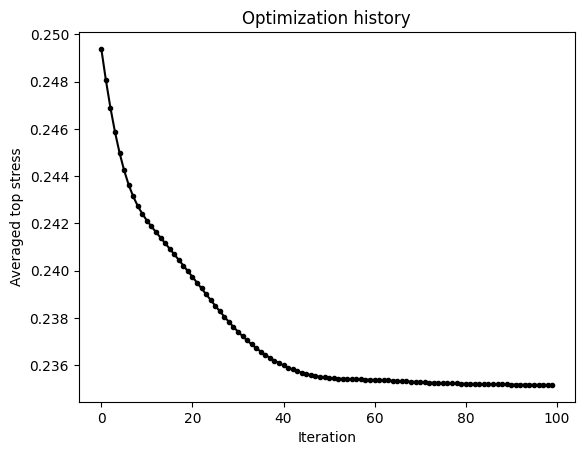

In [8]:
plt.plot(stresses, ".-k")
plt.title("Optimization history")
plt.xlabel("Iteration")
plt.ylabel("Averaged top stress")
plt.show()

Maximum v.Mises stress is 136.09.


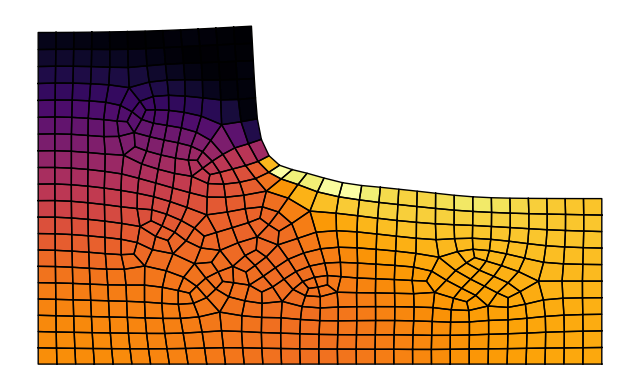

In [9]:
u, _, σ, _, _ = specimen.solve()
mises = torch.sqrt(σ[:, 0] ** 2 - σ[:, 0] * σ[:, 1] + σ[:, 1] ** 2 + 3 * σ[:, 2] ** 2)
specimen.plot(u, bcs=False, element_property=mises, figsize=(8, 8), cmap="inferno")
print(f"Maximum v.Mises stress is {torch.max(mises):.2f}.")